In [1]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display
import os
import gc

In [2]:
print(os.getcwd())

model_repr = {
    "mab": "K-armed Bandit", 
    "ucbnaive": "Naive UCB Approach", 
    "ucbdelta": "UCB-delta Algorithm", 
    "ucbasym": "Asymptotically Optimal UCB", 
    "ucbmoss": "UCB MOSS Algorithm", 
    "thompson": "Thompson Sampling",
    "etc": "Explore-then-commit"
}

model_params = {
    "mab": "epsilon", 
    "ucbnaive": "c", 
    "ucbdelta": "delta", 
    "etc": "explore"  
}

/home/sungwoopark/rl-practice/bandit/MAB


In [3]:
def process(df:pd.DataFrame, no_param:bool):
    ## get cumulative reward
    cumsum_base = np.array([], dtype='float')
    for e in df['sim'].unique():
        rundf = df[df['sim'] == e]
        run_cumsum = np.cumsum(rundf['reward'])
        cumsum_base = np.append(cumsum_base, run_cumsum)
    df['cumulative_reward'] = cumsum_base
    
    ## check if the optimal arm is selected at each run
    df['chosen_optimal'] = (df['chosen_arm'] == df['optimal_arm']).astype('int')
    
    ## groupby
    if no_param:
        result = df[['step', 'reward', 'mean_reward', 'cumulative_reward', 'optimal_reward']].groupby(by='step').mean(numeric_only=False)
    else:
        result = df[['param', 'step', 'reward', 'mean_reward', 'cumulative_reward', 'optimal_reward']].groupby(by=['param', 'step']).mean(numeric_only=False)
    result.reset_index(drop=False, inplace=True)
    
    return result

In [4]:
def procedure(fname, no_param):
    with open(fname, "rb") as f:
        obj = pickle.load(f)
    
    processed = []
    for df in tqdm(obj):
        processed.append(process(df, no_param))
    
    del obj
    gc.collect()
    return processed

In [5]:
def getregret(dfs:list):
    for item in dfs:
        item['rnd_regret'] = np.cumsum(item['optimal_reward'] - item['reward'])
        item['regret'] = np.cumsum(item['optimal_reward'] - item['mean_reward'])        

In [6]:
def getlabel(colname:str):
    split = colname.split('_')
    split[0] = split[0][0].upper() + split[0][1:]
    label = ' '.join(split)
    return label

In [7]:
def plot_results(dfs, model, arm, columns='regret', figsize=(16, 6)):
    ylabel = getlabel(columns)
    plt.figure(figsize=figsize)
    for item in dfs:
        if model in ["thompson", "ucbasym", "ucbmoss"]:
            label = f"{model_repr[model]}"
        else:
            label = f"{model_params[model]}={item['param'].iloc[0]}"
        plt.plot(item[columns], label=label)
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, color='red', linestyle=':')
    plt.legend()
    plt.grid(True)
    plt.xlabel("Step")
    plt.ylabel(ylabel)
    plt.title(f"{model_repr[model]} {ylabel} - {arm} Arm")
    
    plt.tight_layout()
    plt.show()

In [8]:
def summary(dfs, model, column, greedy, is_optimistic=False):
    if is_optimistic:
        flag = "Optimistic "
    else:
        flag = ""
        
    means = [item[column].mean() for item in dfs]
    argmax = np.argmax(means)

    if greedy:
        label = f"{flag}{model_repr[model]}, greedy"
        argmax = 0
    else:
        best_param = dfs[argmax]['param'].iloc[0]
        label = f"{flag}{model_repr[model]}, {model_params[model]}={best_param}"
    
    return argmax, label

In [9]:
os.chdir("./definite")
!ls

eGreedyMAB_BernoulliArm_0.5_Naive_results.pkl
eGreedyMAB_BernoulliArm_0.5_Optimistic_results.pkl
eGreedyMAB_BernoulliArm_1.0_Naive_results.pkl
eGreedyMAB_BernoulliArm_1.0_Optimistic_results.pkl
eGreedyMAB_GaussianArm_0.5_Naive_results.pkl
eGreedyMAB_GaussianArm_0.5_Optimistic_results.pkl
eGreedyMAB_GaussianArm_1.0_Naive_results.pkl
eGreedyMAB_GaussianArm_1.0_Optimistic_results.pkl
ETC_BernoulliArm_1.0_Naive_results.pkl
ETC_GaussianArm_1.0_Naive_results.pkl
ThompsonSampling_BernoulliArm_1.0_Naive_results.pkl
ThompsonSampling_GaussianArm_1.0_Naive_results.pkl
UCBAsymptotic_BernoulliArm_1.0_Naive_results.pkl
UCBAsymptotic_GaussianArm_1.0_Naive_results.pkl
UCBDelta_BernoulliArm_1.0_Naive_results.pkl
UCBDelta_GaussianArm_1.0_Naive_results.pkl
UCBMOSS_BernoulliArm_1.0_Naive_results.pkl
UCBMOSS_GaussianArm_1.0_Naive_results.pkl
UCBNaive_BernoulliArm_1.0_Naive_results.pkl
UCBNaive_GaussianArm_1.0_Naive_results.pkl


In [10]:
mab_bern_1 = procedure(fname="./eGreedyMAB_BernoulliArm_1.0_Naive_results.pkl", no_param=False)
mab_gaus_1 = procedure(fname="./eGreedyMAB_GaussianArm_1.0_Naive_results.pkl", no_param=False)

100%|██████████| 6/6 [00:19<00:00,  3.32s/it]


In [11]:
getregret(mab_bern_1)
getregret(mab_gaus_1)

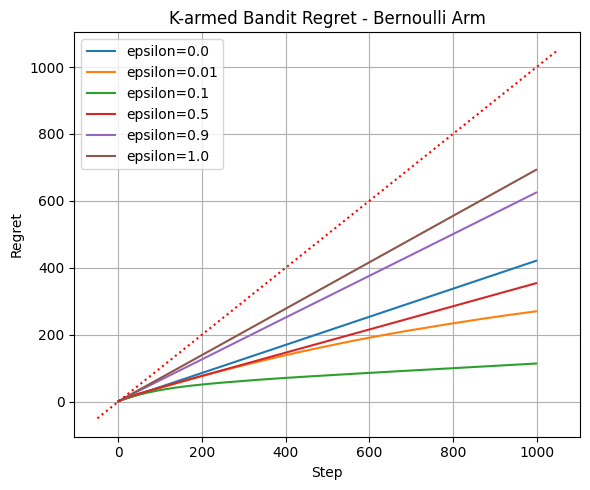

In [14]:
plot_results(mab_bern_1, model="mab", arm="Bernoulli", columns='regret', figsize=(6, 5))

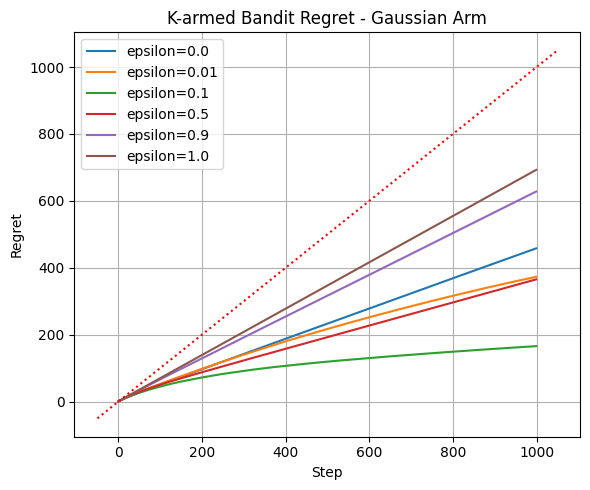

In [15]:
plot_results(mab_gaus_1, model="mab", arm="Gaussian", columns='regret', figsize=(6, 5))